# A suggestion of curse changes for a robot sailboat

## Motivation

The goal of this project is to suggest good points to change the curse of a sailboat while going from point $A$ to point $B$.

This project is done as part of the curse "Maschienen Learning" at the University of Applied Sciences South Westphalia. The code labeling the was writen by the team of the [Sailing Team Darmstadt e.V.](https://www.st-darmstadt.de/). A society of stundens whose goal it is to build the ["roBOOTer"](https://www.st-darmstadt.de/ueber-uns/boote/prototyp-ii/) a fully autonomous sailboat able to cross the atlantic ocean. A technical challenge that was mastered the first time only a few years ago by [a Norwegian team](http://sailbuoy.no/). I myself am part of the Sailing Team Darmstadt e.V. for nearly 10 years.

One of the challenges to solve is a highly efficient way to find a path over the Ocean. The boot is only 2 meters long and powered by solar energy. That makes power a relatively spares commodity.

## Situation as is
At the moment the pathfinding algorithm generates a set of more or less random routes to the goal. Each route than gets optimized by a gradient decent moving the curse change points over the ocean to find a path with the lowest cost that can be found by following the highest gradient. This is relatively inefficient since only local minima can be found for each of the randomly generated route. The route with the lowest cost for the so optimized route will be chosen as the final route.
The idea of this project is to ascertain if it is possible to generate a better initial route through a neural network to give the system a kind of good instinct for the initial routes to reduce optimization steps and the number fo routes that need to be calculated to find a good route. Even tough the initial calculation effort could be high the parallel calculation of 40 routes and lots of optimization steps make it possible that some calculation time and therefore energy can be saved this way.
The idea of this project is to ascertain if it is possible to generate a better initial route through a neural network to give the system a kind of good instinct for the initial routes to reduce optimization steps and the number fo routes that need to be calculated to find a good route. Even tough the initial calculation effort could be high the parallel calculation of 40 routes and lots of optimization steps make it possible that some calculation time and energy can be saved this way.

## The Project

The goal of this project is to calculate a good first route. That allows for some simplifications of this problem.

Some solutions and assumptions can be made.
1. The route proposed by this network will not be the final route. This make a somewhat accurate solution good enough.
2. Since the neural network should not learn how to interpret a specific map but the concept of a map the map can be rotated.
This allows the wind to come always from north.
3. Since curse speed is only somewhat proportional to the wind speed a final course may change depending on wind speed not only direction.
These changes are however somewhat small compared to other influences and can hopefully be ignored since later processing of a proposed route should strait these details out.
4. When the wind comes always from the same direction (After map orientation by wind) map and route can be mirrored allowing to use all data twice for each route.
5. Scale does only matter when the curvature of the earth has a significant influence. Allowing for different scaling of the problem for additional training data.

Since there is a solution for this project that only needs some optimisation we can used labeled data to train the network.

### The generell structure

Since

In [1]:
%cd /pyrate/

/pyrate


In [2]:
!pip install tqdm

In [3]:
import os
from typing import Optional, Final
from math import pi
import glob

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageDraw, Image
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union, split

In [4]:
import experiments
from pyrate.plan.nearplanner.timing_frame import TimingFrame
from pyrate.plan.geometry.route import CartesianRoute

In [5]:
experiments.optimization_param.n_iter_grad = 50
experiments.optimization_param.verbose = False

In [6]:
SIZE_INNER = 75
SIZE_ROUTE = 100
MIN_DESTINATION_DISTANCE = 25

In [7]:
# https://stackoverflow.com/questions/16444719/python-numpy-complex-numbers-is-there-a-function-for-polar-to-rectangular-co
def polar_to_cartesian(
    radii: np.ndarray,
    angles: np.ndarray,
):
    """Transforms polar coordinates into cartesian coordinates.

    Args:
        radii: A array of radii.
        angles: A array of angles.

    Returns:
        An array of cartesian coordinates.
    """
    return radii * np.exp(2j * angles * np.pi)


def cartesian_to_polar(
    x: np.ndarray,
):
    """Transforms cartesian coordinates into polar coordinates.

    Args:
        x: A set of complex number to be separated into polar coordinates.

    Returns:
        An distance array and an angle array.
    """
    return abs(x), np.angle(x)

In [8]:
def random_polygon(
    radius_mean: float = 2,
    radius_sigma: float = 1.5,
):
    """Generates the simplest of polygons, a triangle with a size described by a random polygon.

    Args:
        radius_mean: The average radius defining a circumcircle of a triangle.
        radius_sigma: The variance of a radius defining a circumcircle of a triangle.

    Returns:
        A single triangle.
    """
    number_of_corners = np.random.randint(3, 10)
    array = polar_to_cartesian(
        np.random.lognormal(radius_mean, radius_sigma),
        np.sort(np.random.rand(number_of_corners)),
    )
    offset = np.random.randint(low=-SIZE_ROUTE, high=SIZE_ROUTE, size=(2,))
    return_values = np.zeros((number_of_corners, 2), dtype=float)
    # return_values[1, :] = np.real(offset)
    return_values[:] = offset
    return_values[:, :] += np.array((np.real(array), np.imag(array))).T
    return Polygon(return_values)
    # return np.array( + offset[0], np.imag(array) + offset[1])


random_polygon().exterior.xy

(array('d', [17.51127620448112, 6.747269675298146, 6.0133154595194, 18.947057950054642, 17.51127620448112]),
 array('d', [-58.12293483990852, -54.65585353492957, -54.98056229087878, -63.39394014030877, -58.12293483990852]))

In [9]:
print(random_polygon())

POLYGON ((-11.633473233606555 -10.080092068385213, -14.904531044931492 -12.526815460291699, -14.902438460588852 -13.485855104001587, -10.070348885202387 -15.221857505500772, -9.06908919216602 -13.264510937603255, -9.067607303085786 -13.247542462365493, -11.633473233606555 -10.080092068385213))


In [10]:
def generate_obstacles(
    seed=None,
    number_of_polygons: int = 40,
    radius_mean: float = 2,
    radius_sigma: float = 1,
) -> dict[str, Polygon]:
    """Generates a set of obstacles from a union of triangles.

    The union of triangles meas that if polygons overlap o polygon containing the union of those polygons is returned.
    Args:
        seed: A seed to generate a set of obstacles from.
        number_of_polygons: The number of polygons that should be drawn.
        radius_mean: The average radius defining a circumcircle of an obstacle triangle.
        radius_sigma: The variance of a radius defining a circumcircle of an obstacle triangle.

    Returns:
        A list of unified obstacles.
    """
    if seed is not None:
        np.random.seed(seed)
    polygons = []
    for _ in range(number_of_polygons):
        poly = random_polygon(radius_mean, radius_sigma)
        if poly.contains(Point(0, 0)):
            continue
        if poly.exterior.distance(Point(0, 0)) < 1:
            continue
        polygons.append(poly)
    polygon_list = list(unary_union(polygons).geoms)
    return {str(i): p for i, p in enumerate(polygon_list)}

In [11]:
def generate_destination(
    obstacles: dict[str, Polygon], seed: Optional[int] = None
) -> Point:
    """Generates for a map.

    Can be used to generate a valid destination for list of obstacles.
    Args:
        obstacles: A list of obstacles.
        seed: The seed determining the point.

    Returns:
        A goal that should be reached by the ship.
    """
    # sets the seed
    if seed is not None:
        np.random.seed(seed)

    # generates the point
    point: Optional[Point] = None
    while (
        point is None
        or abs(point.x) < MIN_DESTINATION_DISTANCE
        or abs(point.y) < MIN_DESTINATION_DISTANCE
        or any(obstacle.contains(point) for obstacle in obstacles.values())
    ):
        point = Point(np.random.randint(-SIZE_INNER, SIZE_INNER, size=(2,), dtype=int))
    return point


print(generate_destination(generate_obstacles(42), 42))

POINT (-61 31)


  0%|          | 0/19 [00:00<?, ?it/s]

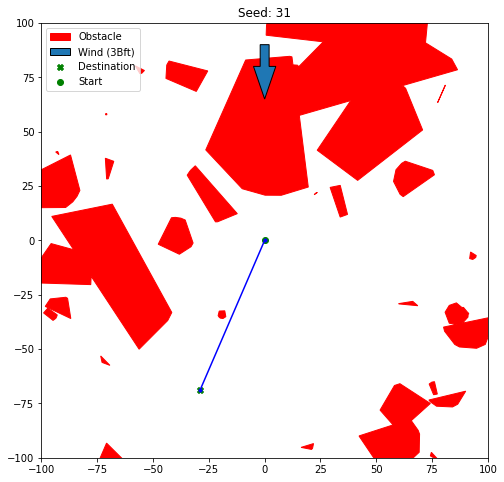

57.23909246162316


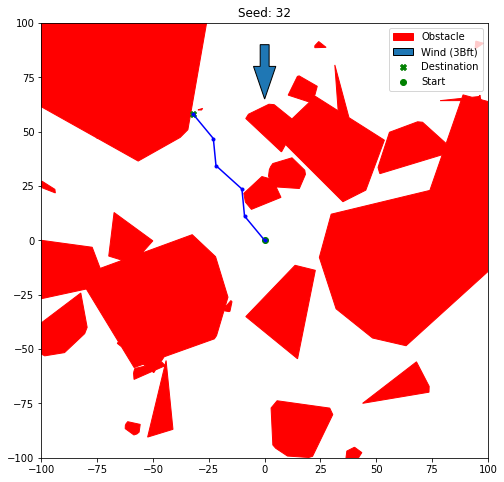

25831.169166603508
Error


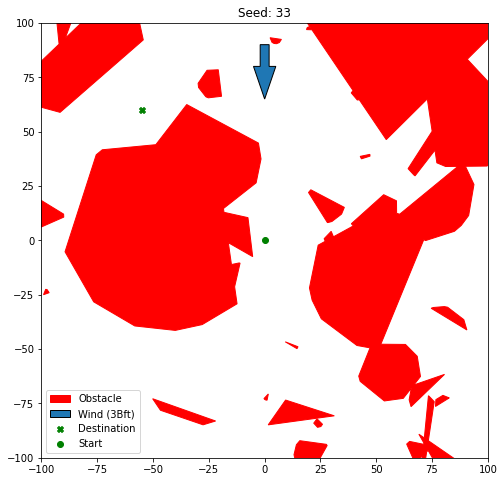

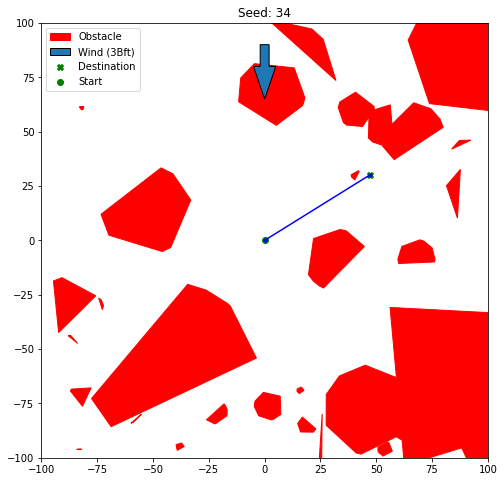

102.22298895814752
Error


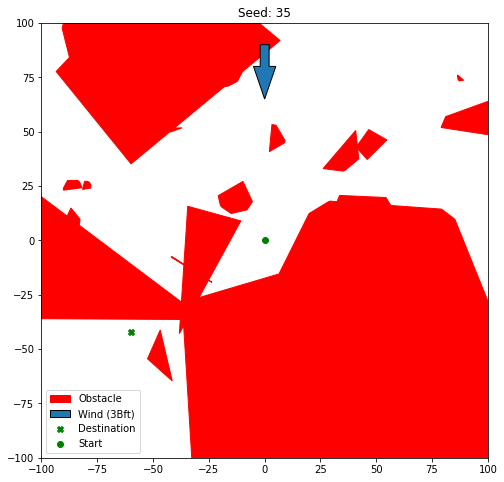

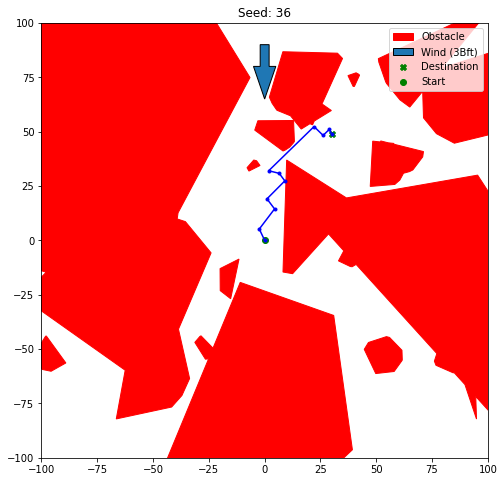

14540.683344260437


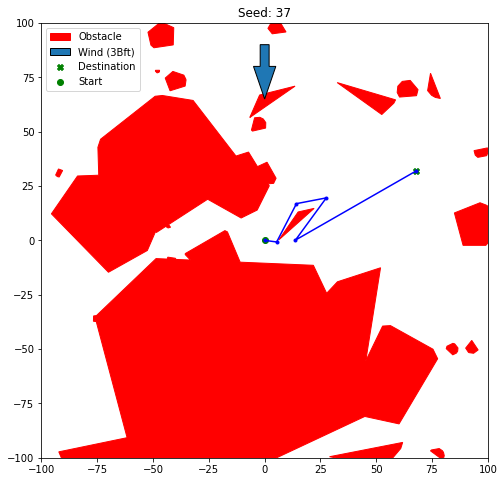

19910.99035961719


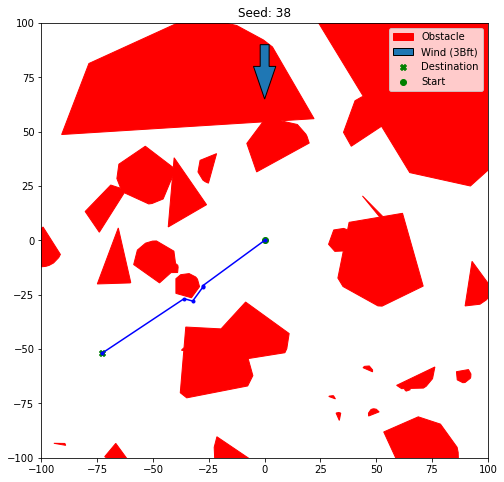

97.28214880128124


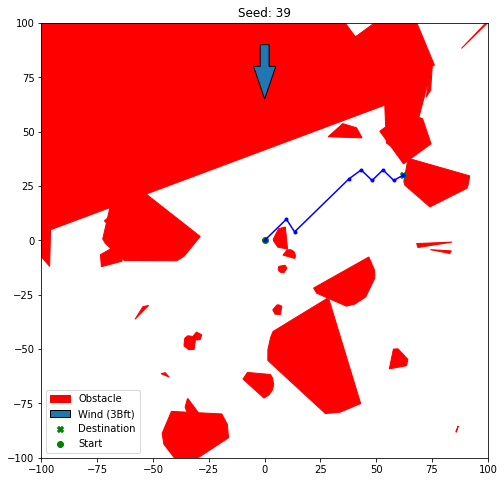

431.6330756470847


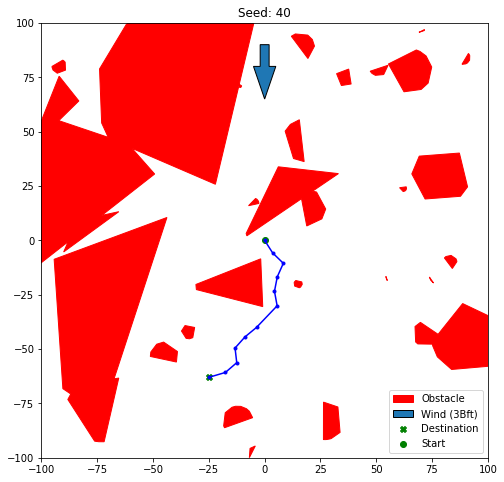

144.97608383310367
Error


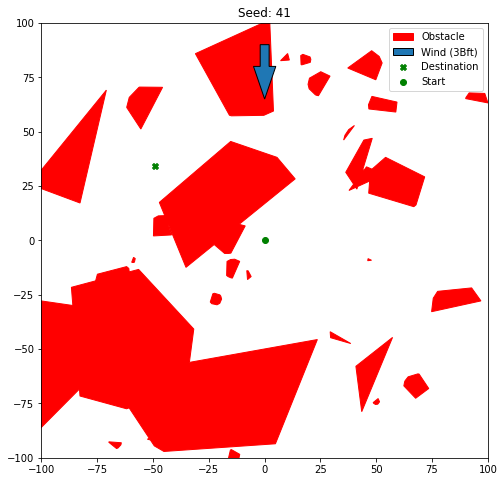

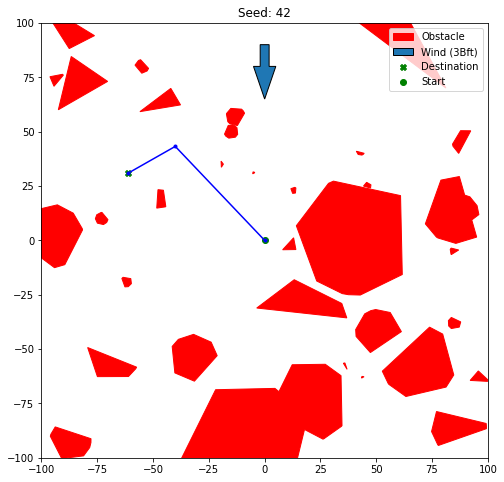

534.5037544444888


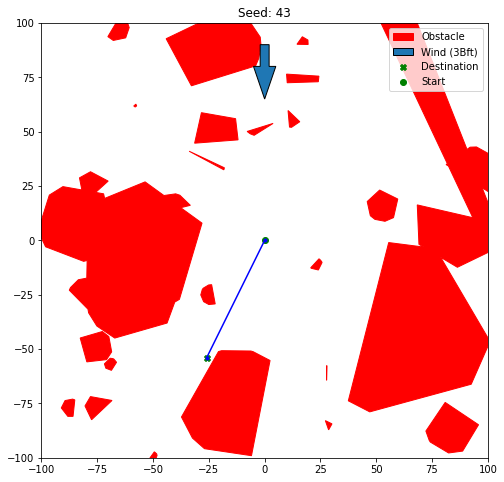

43.341254620524666


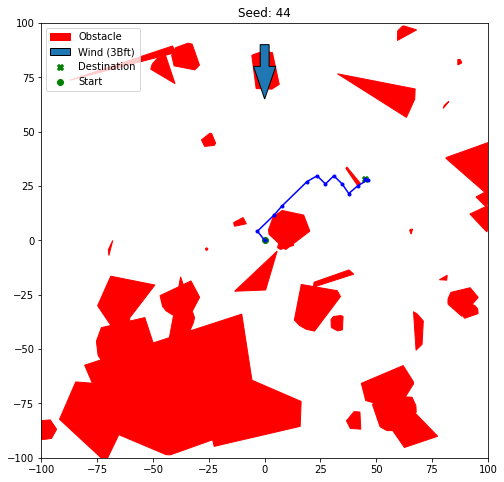

697.876354982896


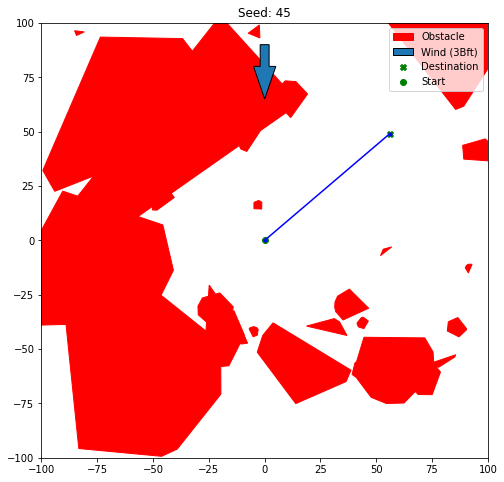

274.2971367700994


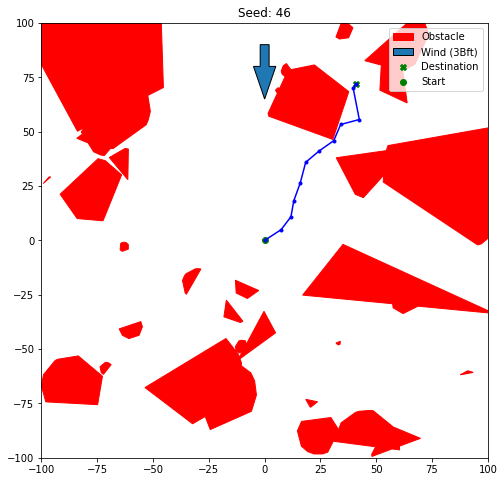

50510.53279699534


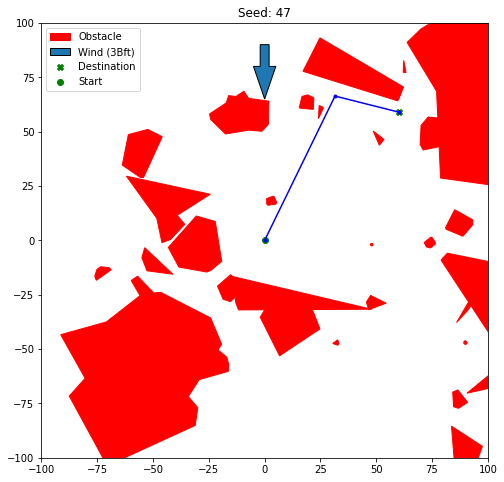

73501.59483882214


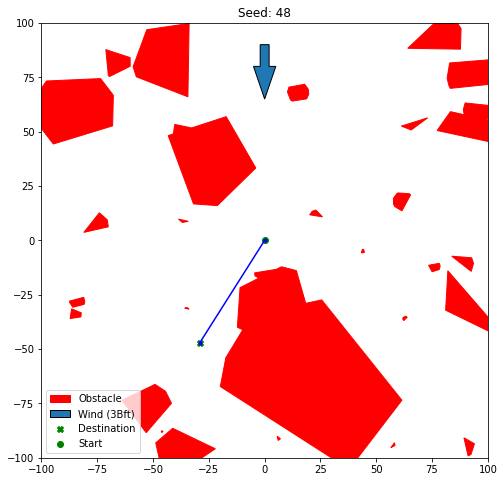

36.28175415214624


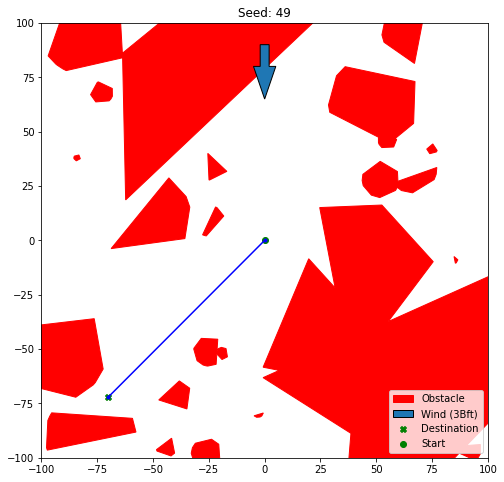

59.99645908379837


In [13]:
def plot_situation(
    obstacles: dict[str, Polygon],
    destination: Point,
    obstacle_color: Optional[str] = None,
    route: Optional[TimingFrame] = None,
    legend: bool = True,
    title: Optional[str] = None,
) -> None:
    """PLots the obstacles into a matplotlib plot.

    Args:
        obstacles: A list of obstacles.
        destination: The destination that should be reached by the boat.
        obstacle_color: The color the obstacles should have. Can be None.
        If none all obstacles will have different colors.
        route: The route that should be plotted.
        legend: If true plots a legend.
        title: The title of the plot.
    Returns:
        None
    """
    plt.figure(figsize=(8, 8))
    # plt.axis([70.9481331655341 - 5, 70.9481331655341 + 5,  43.24219045432384-5, 43.24219045432384+5])
    plt.axis([-SIZE_ROUTE, SIZE_ROUTE, -SIZE_ROUTE, SIZE_ROUTE])

    # Sets a title if one is demanded
    if title:
        plt.title(title)

    # Plots the obsticles.
    if obstacles:
        for polygon in obstacles.values():
            if obstacle_color is not None:
                plt.fill(*polygon.exterior.xy, color=obstacle_color, label="Obstacle")
            else:
                plt.fill(*polygon.exterior.xy)

    # Plots the wind direction
    # https://www.geeksforgeeks.org/matplotlib-pyplot-arrow-in-python/
    plt.arrow(
        0,
        +int(SIZE_ROUTE * 0.9),
        0,
        -int(SIZE_ROUTE * 0.1),
        head_width=10,
        width=4,
        label="Wind (3Bft)",
    )

    if route:
        plt.plot(route.points[:, 0], route.points[:, 1], color="BLUE", marker=".")
        crossing = route.detect_crossing(route.route)
        if crossing:
            plt.plot(*crossing.xy, marker="X", color="YELLOW", label="Crossing")

    # Plots the estination
    if destination:
        plt.scatter(*destination.xy, marker="X", color="green", label="Destination")
    plt.scatter(0, 0, marker="o", color="green", label="Start")

    if legend:
        # https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
    plt.show()


# for seed in tqdm(range(0, 30, 1)):
for seed in tqdm(range(31, 50, 1)):
    wind_dir = 180
    obstacles = generate_obstacles(seed)
    destination = generate_destination(obstacles, seed)
    route = None
    try:
        route, _ = experiments.generate_route(
            position=Point(0, 0),
            goal=destination,
            obstacles=obstacles,
            wind=(18, wind_dir),
        )
    except Exception as e:
        print("Error")
        route = None
    plot_situation(
        obstacles=obstacles,
        destination=destination,
        obstacle_color="RED",
        route=route,
        title=f"Seed: {seed}",
    )
    if route:
        print(route.cost)

In [ ]:
a = [Point(73, 49), Point(70.2287350694941, 41.22346430945754), Point(70.22927795970757, 43.90628272112926)]
LineString(a).crosses(Point(70.9481331655341, 43.24219045432384))

In [ ]:
plot_situation(
    obstacles=obstacles,
    destination=Point(70.9481331655341, 43.24219045432384),
    obstacle_color="RED",
    route=TimingFrame(CartesianRoute.from_shapely(LineString(a))),
    title=f"Seed: {seed}",
)

In [ ]:
# result = snap(Point(70.9481331655341, 43.24219045432384), LineString(a), 0.5)
r = LineString(a)
c = Point(70.9481331655341, 43.24219045432384)

### Create a buffer polygon around the interpolated point
buff = c.buffer(0.0001)

### Split the line on the buffer
first_seg, _, last_seg = split(r, buff)

### Stitch together the first segment, the interpolated point, and the last segment 
r = LineString(list(first_seg.coords) + list(c.coords) + list(last_seg.coords))

first_seg

In [ ]:
plot_situation(
    obstacles=obstacles,
    destination=Point(70.9481331655341, 43.24219045432384),
    obstacle_color="RED",
    route=TimingFrame(CartesianRoute.from_shapely(result)),
    title=f"Seed: {seed}",
)

In [ ]:
def generate_image_from_map(
    obstacles: dict[str, Polygon],
    destination: Point,
    route: Optional[TimingFrame] = None,
) -> Image:
    """Generate an image from the map.

    Can be used to feed an ANN.
    - Obstacles are marked as reed.
    - The destination is marked as green.
    - The points where the route will likely change are blue.

    Args:
        obstacles: A dict of obstacles as shapely Polygons. Keyed as a string.
        destination: A destination that should be navigated to.
    """
    img = Image.new(
        "RGB",
        (SIZE_ROUTE * 2, SIZE_ROUTE * 2),
        "#ffffff",
    )
    draw = ImageDraw.Draw(img)
    for polygon in obstacles.values():
        draw.polygon(
            list(np.dstack(polygon.exterior.xy).reshape((-1)) + SIZE_ROUTE),
            fill="#FF0000",
            outline="#FF0000",
        )
    img.putpixel((int(destination.x) + 100, int(destination.y) + 100), (0, 0xFF, 0))
    return img


seed = 42
wind_dir = 180
obstacles = generate_obstacles(seed)
destination = generate_destination(obstacles, seed)
route = None
try:
    route, _ = experiments.generate_route(
        position=Point(0, 0), goal=destination, obstacles=obstacles, wind=(18, wind_dir)
    )
except Exception as e:
    print("Error")
    print(e)
    route = None
generate_image_from_map(
    obstacles=obstacles,
    destination=destination,
    route=route,
)

In [ ]:
def generate_all_to_series(
    seed: Optional[int] = None, image: bool = False
) -> pd.Series:
    """Generates everything and aggregates all data into a `pd:Series`.

    Args:
        seed:The seed that should be used to generate map and destination.
        image: If an image should be generated or if that should be postponed to save memory.
    Returns:
        Contains a `pd.Series`containing the following.
        - The seed tha generated the map.
        - The destination in x
        - The destination in y
        - A list of Obstacle polygons.
        - The route generated for this map by the roBOOTer navigation system.
        - Optionally the image containing all the information.
          Can be generated at a later date without the fear for a loss of accuracy.
    """
    obstacles = generate_obstacles(seed)
    destination = generate_destination(obstacles, seed)

    try:
        route, _ = experiments.generate_route(
            position=Point(0, 0),
            goal=destination,
            obstacles=obstacles,
            wind=(18, wind_dir),
        )
    except Exception as e:
        print("Error")
        print(e)
        route = None
    return pd.Series(
        data={
            "seed": str(seed),
            "obstacles": obstacles,
            "destination_x": destination.x,
            "destination_y": destination.y,
            "image": generate_image_from_map(obstacles, destination, route)
            if image
            else pd.NA,
            "route": route.points if route else pd.NA,
            "cost": route.cost if route else pd.NA,
        },
        name=str(seed),
    )

In [ ]:
df = pd.DataFrame(
    [generate_all_to_series(i, image=False) for i in tqdm(range(5))]
).set_index("seed")
df.to_pickle("test.pickle")
df

https://programtalk.com/python-examples/PIL.ImageDraw.Draw.polygon/)
https://stackoverflow.com/questions/3654289/scipy-create-2d-polygon-mask

In [ ]:
save_frequency = int(os.getenv("save_frequency", "50"))
start_seed = int(os.getenv("seed_start", "0"))
continues = bool(os.getenv("continues", "true"))

files = glob.glob("data/*.pickle")
seed_groups = {int(file[9:-7]) for file in files}
for next_seeds in range(start_seed, 10_000_000_000, save_frequency):
    if next_seeds in seed_groups:
        continue
    print(f"Start generating routes for seed: {next_seeds}")
    tmp_pickle_str: str = f"data/tmp_{next_seeds:010}.pickle"
    pd.DataFrame().to_pickle(tmp_pickle_str)
    df = pd.DataFrame(
        [
            generate_all_to_series(i, image=False)
            for i in tqdm(range(next_seeds, next_seeds + save_frequency, 1))
        ]
    ).set_index("seed")
    pickle_to_file = f"data/raw_{next_seeds:010}.pickle"
    df.to_pickle(pickle_to_file)
    os.remove(tmp_pickle_str)
    if not continues:
        break

In [ ]:
pd.read_pickle(pickle_to_file)

Ich würde auch zu 1. tendieren, stimme Ihnen aber zu, dass das Thema sehr umfangreich ist. Könnte man sich nicht einen Teilbereich herauspicken? Ich verstehe nicht viel vom Segeln, daher lassen Sie mich kurz zusammenfassen, was Sie vorhaben: - Sie generieren Trainingsdaten mit dem existierenden aber langsamen GD Algorithmus. Ich nehme an, es handelt sich um lokale Routen in einem relativ kleinen Kartenausschnitt. Lässt es die Laufzeit zu, dass Sie eine große Menge an Routen berechnen. - Sie haben dann eine Karte und als Ausgabe eine Liste der Wendepunkte - Warum wollen Sie daraus eine Heatmap berechnen? Diesen Schritt habe ich noch nicht verstanden - Wenn Sie aus einer Karte eine Heatmap trainieren wollen und dafür genügend Beispiele haben, könnnten GANs hilfreich sein: https://arxiv.org/abs/1611.07004 Ich würde Ihnen raten, das Problem möglichst so zu reduzieren, dass es im Rahmen des Moduls noch handhabbar bleibt. Alles Weitere kann man sich auch für spätere Arbeiten aufbewahren. Das 2. Thema ist auch ok. Aber vielleicht nicht ganz so spannend. Ich überlasse Ihnen die Entscheidung. Freundliche Grüße Heiner Giefers

In [ ]:
from shapely.wkt import loads
from shapely.wkt import loads
from shapely.validation import explain_validity
from shapely.geometry.polygon import LinearRing

l = loads(
    "LINESTRING (9603380.577551289 2719693.31939431, 9602238.01822002 2719133.882441244, 9601011.900844947 2718804.012436028, 9599670.800095448 2718931.680117098, 9599567.204161201 2717889.384686942, 9600852.184025297 2721120.409265322, 9599710.80929024 2720511.270897166, 9602777.832940497 2718125.875545334)"
)

print(l.is_simple)  # False

In [ ]:
ring = LinearRing(list(l.coords))

print(ring.is_simple)  # False
print(
    explain_validity(ring)
)  # Ring Self-intersection[9600397.5202531 2719977.17748099]

In [ ]:
a, v = list((1,2,3))

In [ ]:
from shapely.ops import snap

square = Polygon([(1,1), (2, 1), (2, 2), (1, 2), (1, 1)])

line = LineString([(0,0), (0.8, 0.8), (1.8, 0.95), (2.6, 0.5)])

result = snap(line, square, 0.5)

result.wkt

In [ ]:
list(square, line)

In [ ]:
line